<h1>Vector Autoregression Analysis</h1>
<h2>Modeling the Dynamic Interactions Between Multiple Variables</h2>
<p>In this analysis, we will explore the dynamic interactions between multiple variables using vector autoregression.</p>


In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import pandas as pd
from datetime import datetime
import os

import matplotlib.pyplot as plt 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr

pd.set_option('display.max_columns', 500)
pd.set_option('mode.chained_assignment', None)



In [2]:
files = os.listdir('ssw_events_saved_filtered_2/')

In [3]:
# Load all data into one dataframe
df_all = pd.DataFrame()
for file in files:
    df = pd.read_csv("ssw_events_saved_filtered_2/" + file)
    # add an t_ column that is 0 for when SSW_flah is true and increases by 1 after that value and decreases by one before that value
    df = df.sort_values(by='dates', ascending=True)
    # add central date column, that identifies a dataset by its central date
    df['central_date'] = df.iloc[45].dates    
    # concat df with df_all
    df_all = pd.concat([df,df_all])
    


# sort df_all by dates
df_all = df_all.sort_values(by='dates', ascending=True)
# add an index column
df_all['index_'] = range(1, len(df_all) + 1)
# select year to a column
df_all['year'] = pd.DatetimeIndex(df_all['dates']).year
# remove unwanted columns
df_all = df_all.drop(columns = ['wind_eastward_mean','wind_eastward_mean_selection','temperature_mean_selection'])


In [4]:
df_all.head(5)

,dates,wind_eastward_mean_cos,SSW_flag,t_delta,central_date,index_,year
0,2002-12-03,11.278949,False,-45,2003-01-17,1,2002
1,2002-12-04,12.595781,False,-44,2003-01-17,2,2002
2,2002-12-05,12.712304,False,-43,2003-01-17,3,2002
3,2002-12-06,12.365999,False,-42,2003-01-17,4,2002
4,2002-12-07,11.709422,False,-41,2003-01-17,5,2002


In [5]:
# load df_merged into a Pandas DataFrame and merge it with df_all
df_merged = pd.read_csv("mfx_dataframe.csv")

df_merged.head(5)

,dates,mfy_mean,year,mfx_mean,dayofyear,mf_abs
0,2002-08-31,-0.000164,2002,-0.000006,243,0.000164
1,2002-09-01,-0.000069,2002,0.000012,244,0.000070
2,2002-09-02,-0.000100,2002,-0.000014,245,0.000101
3,2002-09-03,-0.000139,2002,-0.000008,246,0.000139
4,2002-09-04,-0.000141,2002,0.000011,247,0.000141


In [6]:
# merge df_all and df_merged on all common dates  
df_all = pd.merge(df_all, df_merged[['dates','mfx_mean','mfy_mean']], on='dates', how='inner')

In [7]:
df_all.head(5)

,dates,wind_eastward_mean_cos,SSW_flag,t_delta,central_date,index_,year,mfx_mean,mfy_mean
0,2002-12-03,11.278949,False,-45,2003-01-17,1,2002,-0.001278,-0.000878
1,2002-12-04,12.595781,False,-44,2003-01-17,2,2002,-0.000908,-0.000904
2,2002-12-05,12.712304,False,-43,2003-01-17,3,2002,-0.000548,-0.000247
3,2002-12-06,12.365999,False,-42,2003-01-17,4,2002,-0.000397,0.000196
4,2002-12-07,11.709422,False,-41,2003-01-17,5,2002,-0.000528,0.000014


In [8]:
# Calculate avs and stds to plot over time for all ssw
avgs = df_all.mean()
devs = df_all.std()

for col in ['mfx_mean', 'wind_eastward_mean_cos']:
    df_all[f"{col}_zscore"] = (df_all[col] - avgs.loc[col]) / devs.loc[col]

/var/folders/p6/325r0tsd2cd1jddpt9nd70hm0000gn/T/ipykernel_1859/719125403.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  avgs = df_all.mean()
/var/folders/p6/325r0tsd2cd1jddpt9nd70hm0000gn/T/ipykernel_1859/719125403.py:3: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  devs = df_all.std()


In [9]:
df_all

,dates,wind_eastward_mean_cos,SSW_flag,t_delta,central_date,index_,year,mfx_mean,mfy_mean,mfx_mean_zscore,wind_eastward_mean_cos_zscore
0,2002-12-03,11.278949,False,-45,2003-01-17,1,2002,-0.001278,-0.000878,-0.319383,0.672986
1,2002-12-04,12.595781,False,-44,2003-01-17,2,2002,-0.000908,-0.000904,-0.105940,0.840944
2,2002-12-05,12.712304,False,-43,2003-01-17,3,2002,-0.000548,-0.000247,0.101798,0.855806
3,2002-12-06,12.365999,False,-42,2003-01-17,4,2002,-0.000397,0.000196,0.189335,0.811636
4,2002-12-07,11.709422,False,-41,2003-01-17,5,2002,-0.000528,0.000014,0.113651,0.727892
...,...,...,...,...,...,...,...,...,...,...,...
826,2018-03-24,-0.479887,False,41,2018-02-11,815,2018,0.000027,-0.000065,0.434082,-0.826819
827,2018-03-25,-1.619390,False,42,2018-02-11,816,2018,-0.000042,-0.000138,0.394401,-0.972159
828,2018-03-26,-2.632415,False,43,2018-02-11,817,2018,-0.000015,-0.000078,0.409652,-1.101368
829,2018-03-27,-1.319749,False,44,2018-02-11,818,2018,-0.000032,-0.000086,0.400204,-0.933941


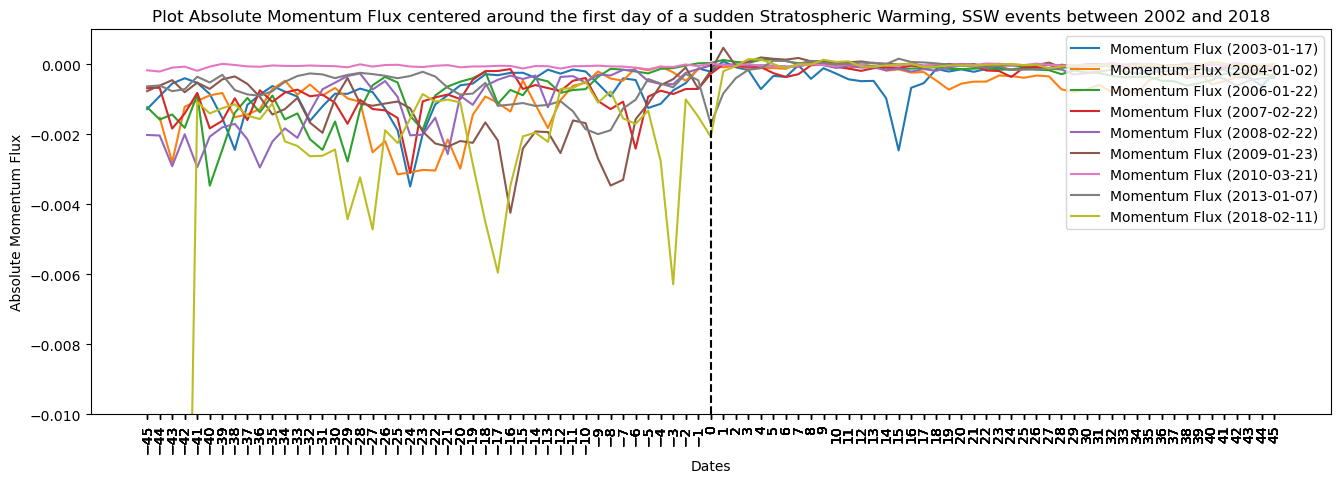

In [10]:
# =================================================================================================
# Plot absolute Momemtum flux with Matplotlib
# =================================================================================================

import matplotlib.pyplot as plt

df = df_all
df_grouped = df.groupby('central_date')
fig, ax1 = plt.subplots(figsize=(16, 5))

for year, dataframe in df_grouped:
    # ax1.plot(dataframe['t_delta'], dataframe['mf_abs'], label=f'Momentum Flux ({year})')
    ax1.plot(dataframe['t_delta'], dataframe['mfx_mean'], label=f'Momentum Flux ({year})')

    
# Set the axis labels and titles
ax1.set_xlabel('Dates')
ax1.set_ylabel('Absolute Momentum Flux')
ax1.set_ylim([-0.01,0.001])
# add ticks for each value in the x axis, every 2nd value
ticks = df['t_delta'][::1]
ax1.set_xticks(ticks)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)

# format the x axis ticks


# add vertical line at t_delta = 0
ax1.axvline(x=0, color='black', linestyle='--')


plt.title('Plot Absolute Momentum Flux centered around the first day of a sudden Stratospheric Warming, SSW events between 2002 and 2018')
plt.legend(loc='upper right')

plt.show()


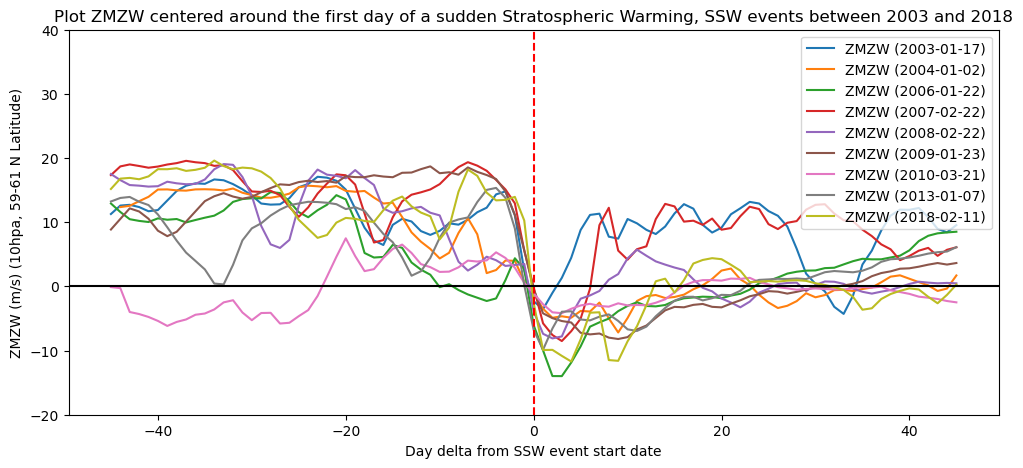

In [11]:
import matplotlib.pyplot as plt

plt.style.use('default')

df = df_all

df_grouped = df.groupby('central_date')

fig, ax1 = plt.subplots(figsize=(12, 5))

for year, dataframe in df_grouped:
    ax1.plot(dataframe['t_delta'], dataframe['wind_eastward_mean_cos'], label=f'ZMZW ({year})')
    
# Set the axis labels and titles
ax1.set_xlabel('Day delta from SSW event start date')
ax1.set_ylabel('ZMZW (m/s) (10hpa, 59-61 N Latitude)')
ax1.set_ylim([-20, 40])
ax1.tick_params(axis='y')

# add vertical line at t_delta = 0
ax1.axvline(x=0, color='red', linestyle='--')

# add horizontal line at y=0
ax1.axhline(y=0, color='black', linestyle='-')

plt.title('Plot ZMZW centered around the first day of a sudden Stratospheric Warming, SSW events between 2003 and 2018')
plt.legend(loc='upper right')

plt.show()
